# Exploring the Suburbs of Colombo to Open a Bakery

## Scrape the DS Divisions in Colombo district and their population

In [42]:
import requests
#access rge url
wiki_url = requests.get("https://en.wikipedia.org/wiki/Colombo_District").text

from bs4 import BeautifulSoup
#scrape the web page
wiki_soup = BeautifulSoup(wiki_url,"lxml")

#extract the table
wiki_table = wiki_soup.find("table",{"class":"wikitable"})

#extract the <td> elements
elements = [item.get_text(strip = True) for item in wiki_table.find_all('td')]

divsec = []
population = []

#1st element is divisional secretariat
for i in range(0, len(elements), 12):
    divsec.append(elements[i])

#remove the element 'Total'
divsec.remove("Total")
    
#10th element is total population
for j in range(10, len(elements), 12):
    population.append(int(elements[j].replace(',', '')))

#combine the two arrays to create a table
population_table = {"DivSec":divsec, "Population":population}

In [43]:
import pandas as pd
#convert the table into a dataframe
colombo_suburbs = pd.DataFrame(population_table)
colombo_suburbs

,DivSec,Population
0,Colombo,318048
1,Dehiwala,87834
2,Homagama,236179
3,Kaduwela,252057
4,Kesbewa,244062
5,Kolonnawa,190817
6,Maharagama,195355
7,Moratuwa,167160
8,Padukka,65167
9,Ratmalana,95162


In [44]:
#drop "Colombo" and "Thimbirigasyaya" as they are within Colombo city limits
colombo_suburbs = colombo_suburbs.drop(colombo_suburbs[(colombo_suburbs['DivSec'] == "Colombo") | (colombo_suburbs['DivSec'] == "Thimbirigasyaya")].index)
#rename "Sri Jayawardenepura Kotte" as "Kotte"
colombo_suburbs.loc[colombo_suburbs.DivSec == "Sri Jayawardenepura Kotte", "DivSec"] = "Kotte"
#reset the index
colombo_suburbs.index = range(len(colombo_suburbs))
colombo_suburbs

,DivSec,Population
0,Dehiwala,87834
1,Homagama,236179
2,Kaduwela,252057
3,Kesbewa,244062
4,Kolonnawa,190817
5,Maharagama,195355
6,Moratuwa,167160
7,Padukka,65167
8,Ratmalana,95162
9,Seethawaka,113477


## Scrape property prices as an additional information

In [45]:
property_url = requests.get("https://www.lankapropertyweb.com/house_prices.php").text
property_soup = BeautifulSoup(property_url,"lxml")
tables = property_soup.find_all("table",{"class":"table table-striped"})
price_table = tables[4]

elements = [item.get_text(strip = True) for item in price_table.find_all('td')]

divsec = []
perch_price = []

for i in range(2, len(elements), 2):
    divsec.append(elements[i])

for j in range(3, len(elements), 2):
    perch_price.append(int(elements[j].replace(',', '')))

#combine the two arrays to create a table
price_table = {"DivSec":divsec, "Land Price":perch_price}

In [46]:
land_prices = pd.DataFrame(price_table)
land_prices.head()

,DivSec,Land Price
0,Aluthgama,278286
1,Angoda,536255
2,Athurugiriya,344404
3,Avissawella,164454
4,Bandaragama,167155


In [47]:
#data cleaning required in land_price

#rename "Rathmalana" as "Ratmalana"
land_prices.loc[land_prices.DivSec == "Rathmalana", "DivSec"] = "Ratmalana"

#assume land price of "Kotte" is similar to "Ethul Kotte"
land_prices.loc[land_prices.DivSec == "Ethul Kotte", "DivSec"] = "Kotte"

#assume land price of "Seethawaka" is similar to "Avissawella"
land_prices.loc[land_prices.DivSec == "Avissawella", "DivSec"] = "Seethawaka"

#reset the index
land_prices.index = range(len(land_prices))

In [48]:
#join the two tables based on "DivSec"
colombo_suburbs = colombo_suburbs.merge(land_prices, on = "DivSec", how = 'left')
colombo_suburbs

,DivSec,Population,Land Price
0,Dehiwala,87834,3131549
1,Homagama,236179,271067
2,Kaduwela,252057,350032
3,Kesbewa,244062,353686
4,Kolonnawa,190817,825000
5,Maharagama,195355,1030166
6,Moratuwa,167160,809972
7,Padukka,65167,95720
8,Ratmalana,95162,1112115
9,Seethawaka,113477,164454


## Adding coordinates of each DS Division

In [49]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "CO_Explorer")

latitudes = []
longitudes = []

for i in range(0, len(colombo_suburbs["DivSec"])):
    address = colombo_suburbs["DivSec"][i]
    location = geolocator.geocode(address)
    if location != None:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    else:
        latitudes.append("NaN")
        longitudes.append("NaN")

In [50]:
colombo_suburbs["Latitude"] = latitudes
colombo_suburbs["Longitude"] = longitudes
colombo_suburbs

,DivSec,Population,Land Price,Latitude,Longitude
0,Dehiwala,87834,3131549,6.851279,79.865977
1,Homagama,236179,271067,6.841273,80.003058
2,Kaduwela,252057,350032,6.935703,79.984331
3,Kesbewa,244062,353686,6.795740,79.940848
4,Kolonnawa,190817,825000,6.932625,79.890314
5,Maharagama,195355,1030166,6.847278,79.926608
6,Moratuwa,167160,809972,6.774682,79.882610
7,Padukka,65167,95720,6.841538,80.091647
8,Ratmalana,95162,1112115,6.815259,79.866778
9,Seethawaka,113477,164454,6.952948,80.218633


## Clustering DS Divisions

Define Foursquare credentials and version

In [51]:
CLIENT_ID = '4QGI5VA5QPLHKUOVIGTS4DX0E4XLHORRPRIECVOJFOYY33OW'
CLIENT_SECRET = 'QHJEYKOOOH0AMRYLYGWLRUWS2ELQPA54PSQUV52SHHYCVYAN'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4QGI5VA5QPLHKUOVIGTS4DX0E4XLHORRPRIECVOJFOYY33OW
CLIENT_SECRET:QHJEYKOOOH0AMRYLYGWLRUWS2ELQPA54PSQUV52SHHYCVYAN


Define a function to repeat the same process to all the divisional secretariats in Colombo

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['DivSec', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [53]:
LIMIT = 100
venues = getNearbyVenues(names = colombo_suburbs['DivSec'],
                                   latitudes = colombo_suburbs['Latitude'],
                                   longitudes = colombo_suburbs['Longitude']
                                  )

Dehiwala
Homagama
Kaduwela
Kesbewa
Kolonnawa
Maharagama
Moratuwa
Padukka
Ratmalana
Seethawaka
Kotte


Group the venues by neighborhood

In [54]:
venues.groupby('DivSec').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
DivSec,,,,,,
Dehiwala,21,21,21,21,21,21
Homagama,5,5,5,5,5,5
Kaduwela,11,11,11,11,11,11
Kesbewa,6,6,6,6,6,6
Kolonnawa,4,4,4,4,4,4
Kotte,4,4,4,4,4,4
Maharagama,20,20,20,20,20,20
Moratuwa,4,4,4,4,4,4
Padukka,3,3,3,3,3,3


Analyze Colombo district

In [55]:
# one hot encoding
colombo_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add DivSec column back to dataframe
colombo_onehot['DivSec'] = venues['DivSec'] 

# move DivSec column to the first column
fixed_columns = [colombo_onehot.columns[-1]] + list(colombo_onehot.columns[:-1])
colombo_onehot = colombo_onehot[fixed_columns]

colombo_onehot.head()

,DivSec,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beach,Bookstore,Boutique,Breakfast Spot,...,Pharmacy,Pizza Place,Platform,Playground,Shoe Store,Shopping Mall,Supermarket,Theme Park,Train Station,Women's Store
0,Dehiwala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Dehiwala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dehiwala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dehiwala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dehiwala,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by city and by taking the mean of the frequency of occurrence of each category

In [56]:
colombo_grouped = colombo_onehot.groupby('DivSec').mean().reset_index()
colombo_grouped

,DivSec,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beach,Bookstore,Boutique,Breakfast Spot,...,Pharmacy,Pizza Place,Platform,Playground,Shoe Store,Shopping Mall,Supermarket,Theme Park,Train Station,Women's Store
0,Dehiwala,0.0,0.047619,0.047619,0.00,0.000000,0.00,0.047619,0.000000,0.000000,...,0.000000,0.095238,0.00,0.047619,0.00,0.00,0.000000,0.00,0.047619,0.047619
1,Homagama,0.0,0.000000,0.000000,0.20,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.200000,0.00,0.000000,0.000000
2,Kaduwela,0.0,0.000000,0.090909,0.00,0.090909,0.00,0.000000,0.181818,0.090909,...,0.090909,0.090909,0.00,0.000000,0.00,0.00,0.090909,0.00,0.000000,0.000000
3,Kesbewa,0.0,0.000000,0.000000,0.00,0.166667,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.166667,0.00,0.000000,0.000000
4,Kolonnawa,0.0,0.000000,0.250000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000
5,Kotte,0.5,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.25,0.000000,0.000000
6,Maharagama,0.0,0.000000,0.050000,0.05,0.000000,0.00,0.050000,0.050000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.05,0.05,0.100000,0.00,0.050000,0.050000
7,Moratuwa,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.250000,0.000000
8,Padukka,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.333333,0.000000
9,Ratmalana,0.0,0.000000,0.250000,0.00,0.000000,0.25,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.25,0.000000,0.00,0.00,0.000000,0.00,0.250000,0.000000


Define a function to sort the venues in descending order

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each division

In [58]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['DivSec']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
divsec_venues_sorted = pd.DataFrame(columns = columns)
divsec_venues_sorted['DivSec'] = colombo_grouped['DivSec']

for ind in np.arange(colombo_grouped.shape[0]):
    divsec_venues_sorted.iloc[ind, 1:] = return_most_common_venues(colombo_grouped.iloc[ind, :], num_top_venues)

divsec_venues_sorted

,DivSec,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dehiwala,Clothing Store,Cosmetics Shop,Pizza Place,Women's Store,Flea Market,Asian Restaurant,Bakery,Bookstore,Café,Candy Store
1,Homagama,Bus Station,Supermarket,Bank,Clothing Store,Chinese Restaurant,Women's Store,Cosmetics Shop,Convenience Store,Candy Store,Café
2,Kaduwela,Boutique,Bus Station,Supermarket,Bakery,Bar,Chinese Restaurant,Pizza Place,Pharmacy,Breakfast Spot,Women's Store
3,Kesbewa,Lake,Supermarket,Bar,Café,Grocery Store,Bus Station,Women's Store,Convenience Store,Clothing Store,Chinese Restaurant
4,Kolonnawa,Fast Food Restaurant,Bakery,Convenience Store,Department Store,Bank,Bar,Beach,Bookstore,Boutique,Electronics Store
5,Kotte,Arts & Crafts Store,Theme Park,Garden,Breakfast Spot,Convenience Store,Clothing Store,Chinese Restaurant,Candy Store,Café,Bus Station
6,Maharagama,Bus Station,Chinese Restaurant,Supermarket,Women's Store,Bookstore,Electronics Store,Train Station,Food Court,Fruit & Vegetable Store,Boutique
7,Moratuwa,Train Station,Bus Station,Clothing Store,Chinese Restaurant,Department Store,Cosmetics Shop,Convenience Store,Candy Store,Café,Women's Store
8,Padukka,Train Station,Bus Station,Hotel,Cosmetics Shop,Convenience Store,Clothing Store,Chinese Restaurant,Candy Store,Café,Women's Store
9,Ratmalana,Train Station,Bakery,Beach,Platform,Bus Station,Cosmetics Shop,Convenience Store,Clothing Store,Chinese Restaurant,Candy Store


Run k-means to cluster the neighborhood into 3 clusters.

In [59]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

colombo_grouped_clustering = colombo_grouped.drop('DivSec', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(colombo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 0, 2, 2, 2, 2], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [60]:
# add clustering labels
divsec_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

colombo_merged = colombo_suburbs

# merge colombo_grouped with divsec_venues_sorted to add latitude/longitude for each neighborhood
colombo_merged = colombo_merged.join(divsec_venues_sorted.set_index('DivSec'), on = 'DivSec')

colombo_merged

,DivSec,Population,Land Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dehiwala,87834,3131549,6.851279,79.865977,2,Clothing Store,Cosmetics Shop,Pizza Place,Women's Store,Flea Market,Asian Restaurant,Bakery,Bookstore,Café,Candy Store
1,Homagama,236179,271067,6.841273,80.003058,2,Bus Station,Supermarket,Bank,Clothing Store,Chinese Restaurant,Women's Store,Cosmetics Shop,Convenience Store,Candy Store,Café
2,Kaduwela,252057,350032,6.935703,79.984331,2,Boutique,Bus Station,Supermarket,Bakery,Bar,Chinese Restaurant,Pizza Place,Pharmacy,Breakfast Spot,Women's Store
3,Kesbewa,244062,353686,6.795740,79.940848,2,Lake,Supermarket,Bar,Café,Grocery Store,Bus Station,Women's Store,Convenience Store,Clothing Store,Chinese Restaurant
4,Kolonnawa,190817,825000,6.932625,79.890314,2,Fast Food Restaurant,Bakery,Convenience Store,Department Store,Bank,Bar,Beach,Bookstore,Boutique,Electronics Store
5,Maharagama,195355,1030166,6.847278,79.926608,2,Bus Station,Chinese Restaurant,Supermarket,Women's Store,Bookstore,Electronics Store,Train Station,Food Court,Fruit & Vegetable Store,Boutique
6,Moratuwa,167160,809972,6.774682,79.882610,2,Train Station,Bus Station,Clothing Store,Chinese Restaurant,Department Store,Cosmetics Shop,Convenience Store,Candy Store,Café,Women's Store
7,Padukka,65167,95720,6.841538,80.091647,2,Train Station,Bus Station,Hotel,Cosmetics Shop,Convenience Store,Clothing Store,Chinese Restaurant,Candy Store,Café,Women's Store
8,Ratmalana,95162,1112115,6.815259,79.866778,2,Train Station,Bakery,Beach,Platform,Bus Station,Cosmetics Shop,Convenience Store,Clothing Store,Chinese Restaurant,Candy Store
9,Seethawaka,113477,164454,6.952948,80.218633,1,Clothing Store,Women's Store,Electronics Store,Cosmetics Shop,Convenience Store,Chinese Restaurant,Candy Store,Café,Bus Station,Breakfast Spot


Visualize the resulting clusters.

In [61]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

latitude = colombo_merged.iloc[0]["Latitude"]
longitude = colombo_merged.iloc[0]["Longitude"]

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(colombo_merged['Latitude'], colombo_merged['Longitude'], colombo_merged['DivSec'], colombo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

## Narrow down the analysis to bakeries

In [62]:
#identify the number of popular bakeries in each divisional secretariat
bakeries = colombo_onehot[['DivSec', 'Bakery']]
colombo_bakeries = bakeries.groupby('DivSec', as_index = False).count()
colombo_bakeries

,DivSec,Bakery
0,Dehiwala,21
1,Homagama,5
2,Kaduwela,11
3,Kesbewa,6
4,Kolonnawa,4
5,Kotte,4
6,Maharagama,20
7,Moratuwa,4
8,Padukka,3
9,Ratmalana,4


In [63]:
#merge with population and land price data
colombo_bakeries = colombo_bakeries.merge(colombo_suburbs, on = "DivSec")[['DivSec', 'Bakery', 'Population', 'Land Price']]
colombo_bakeries

,DivSec,Bakery,Population,Land Price
0,Dehiwala,21,87834,3131549
1,Homagama,5,236179,271067
2,Kaduwela,11,252057,350032
3,Kesbewa,6,244062,353686
4,Kolonnawa,4,190817,825000
5,Kotte,4,107508,2010233
6,Maharagama,20,195355,1030166
7,Moratuwa,4,167160,809972
8,Padukka,3,65167,95720
9,Ratmalana,4,95162,1112115


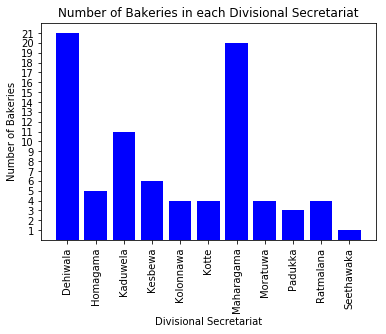

In [64]:
#visualize the data

import matplotlib as mp
import matplotlib.pyplot as plt
import math

data = colombo_bakeries[['DivSec', 'Bakery']]
x = data.DivSec
y = data.Bakery

plt.bar(x, y, color = 'blue')

plt.xticks(rotation = 'vertical')

yint = range(min(y), math.ceil(max(y))+1)
plt.yticks(yint)

plt.title('Number of Bakeries in each Divisional Secretariat')
plt.xlabel('Divisional Secretariat')
plt.ylabel('Number of Bakeries')

plt.show()

In [65]:
#visualize this on a map

#create the scale
threshold_scale = np.linspace(colombo_bakeries['Bakery'].min(),
                              colombo_bakeries['Bakery'].max(),
                              6, dtype = int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum bakeries

#geojson file
sl_geo = r'LKA_CO.json'

#create a plain map around Colombo
sl_map = folium.Map(location = [6.9271, 79.8612], zoom_start = 10, tiles = 'Open street map')

#generate choropleth map using the number of bakeries
sl_map.choropleth(
    geo_data = sl_geo,
    data = colombo_bakeries,
    columns = ['DivSec', 'Bakery'],
    key_on = 'feature.properties.DivSec',
    threshold_scale = threshold_scale,
    fill_color = 'YlGn',
    fill_opacity = 0.5, 
    line_opacity = 0.2,
    legend_name = 'Bakeries in Colombo Suburbs',
    reset = True
)

sl_map

In [66]:
#calculate the number of bakeries catering to 100,000 people
colombo_bakeries['Bakeries per 100,000'] = round(colombo_bakeries['Bakery']/(colombo_bakeries['Population']/100000),1)
colombo_bakeries

,DivSec,Bakery,Population,Land Price,"Bakeries per 100,000"
0,Dehiwala,21,87834,3131549,23.9
1,Homagama,5,236179,271067,2.1
2,Kaduwela,11,252057,350032,4.4
3,Kesbewa,6,244062,353686,2.5
4,Kolonnawa,4,190817,825000,2.1
5,Kotte,4,107508,2010233,3.7
6,Maharagama,20,195355,1030166,10.2
7,Moratuwa,4,167160,809972,2.4
8,Padukka,3,65167,95720,4.6
9,Ratmalana,4,95162,1112115,4.2


In [67]:
#sort the dataset based on the number of bakeries per 100,000 people and then by land price
colombo_bakeries = colombo_bakeries.sort_values(['Bakeries per 100,000', 'Land Price']).reset_index(drop = True)
colombo_bakeries

,DivSec,Bakery,Population,Land Price,"Bakeries per 100,000"
0,Seethawaka,1,113477,164454,0.9
1,Homagama,5,236179,271067,2.1
2,Kolonnawa,4,190817,825000,2.1
3,Moratuwa,4,167160,809972,2.4
4,Kesbewa,6,244062,353686,2.5
5,Kotte,4,107508,2010233,3.7
6,Ratmalana,4,95162,1112115,4.2
7,Kaduwela,11,252057,350032,4.4
8,Padukka,3,65167,95720,4.6
9,Maharagama,20,195355,1030166,10.2


In [68]:
#rename columns
colombo_bakeries.columns = ['DivSec', 'No of Bakeries', 'Population', 'Land Price', 'Bakeries per 100,000']

#reorder columns
columns = list(colombo_bakeries.columns)
a, b = columns.index('Land Price'), columns.index('Bakeries per 100,000')
columns[b], columns[a] = columns[a], columns[b]
colombo_bakeries = colombo_bakeries[columns]

colombo_bakeries

,DivSec,No of Bakeries,Population,"Bakeries per 100,000",Land Price
0,Seethawaka,1,113477,0.9,164454
1,Homagama,5,236179,2.1,271067
2,Kolonnawa,4,190817,2.1,825000
3,Moratuwa,4,167160,2.4,809972
4,Kesbewa,6,244062,2.5,353686
5,Kotte,4,107508,3.7,2010233
6,Ratmalana,4,95162,4.2,1112115
7,Kaduwela,11,252057,4.4,350032
8,Padukka,3,65167,4.6,95720
9,Maharagama,20,195355,10.2,1030166


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


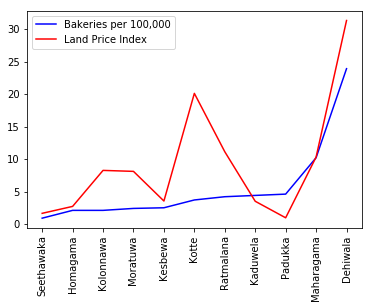

In [69]:
#visualize data
data = colombo_bakeries[['DivSec', 'Bakeries per 100,000']]
data['Land Price Index'] = colombo_bakeries['Land Price']/100000

plt.plot('DivSec', 'Bakeries per 100,000', data = data, color = 'blue')
plt.plot('DivSec', 'Land Price Index', data = data, color = 'red')
plt.xticks(rotation = 'vertical')
plt.legend()